In [51]:
import pandas as pd

from config import RAW_DATA_PATH

import os
import re

from keras.preprocessing.text import text_to_word_sequence
from collections import Counter

import matplotlib.pyplot as plt

from spacy.lang.fr import STOP_WORDS
from spacy import load

nlp = load('fr_core_news_sm')


`python -m spacy download fr_core_news_sm`

# Load the data

In [52]:
df = pd.read_csv(os.path.join(RAW_DATA_PATH, 'CADA-2022-05-31.csv'), sep=',')

In [53]:
df.head()

,Numéro de dossier,Administration,Type,Année,Séance,Objet,Thème et sous thème,Mots clés,Sens et motivation,Partie,Avis
0,19840002,ministre de la défense,Avis,1984,03/03/1984,[Voir avis],"Justice, Ordre Public Et Sécurité/Défense Et D...",Armée,Défavorable/Défense,III,La commission d'accès aux documents administra...
1,19840003,ministre de la défense,Avis,1984,13/12/1984,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Armée,"Irrecevable/Imprécise, Défavorable/Défense, In...",III,La commission d'accès aux documents administra...
2,19850001,"ministre de l'économie, des finances et du budget",Avis,1985,05/12/1985,[Voir avis],"Justice, Ordre Public Et Sécurité/Association,...",NaN,Défavorable,III,La commission d'accès aux documents administra...
3,19860001,directeur départemental du travail et de l'emp...,Conseil,1986,30/01/1986,(voir avis),Travail Et Emploi/Droit Du Travail,"Licenciement, Conditions de travail","Défavorable/Procédure, Sans objet",III,La commission d'accès aux documents administra...
4,19870061,gouverneur de la Banque de France,Avis,1987,02/04/1987,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Banques et assurances,"Défavorable/Sécurité publique, Favorable/Sauf ...",III,La commission d'accès aux documents administra...


# Global stats

In [54]:
len(df)

48746

In [55]:
df.dtypes

Numéro de dossier       int64
Administration         object
Type                   object
Année                   int64
Séance                 object
Objet                  object
Thème et sous thème    object
Mots clés              object
Sens et motivation     object
Partie                 object
Avis                   object
dtype: object

In [56]:
df['Avis'] = df['Avis'].astype(str)

# Distribution of variables

In [57]:
df['Administration'].nunique()

14768

In [58]:
df['Type'].value_counts()

Avis        45789
Conseil      2954
Sanction        3
Name: Type, dtype: int64

In [59]:
df['Année'].value_counts().sort_index(ascending=False).head(20)

2021    3245
2020    7118
2019    5291
2018    4241
2017    5805
2016    4712
2015    5045
2014    4477
2013    4779
2012     771
2011     155
2010     155
2009     222
2008     302
2007     416
2006     379
2005     206
2004     130
2003     214
2002     249
Name: Année, dtype: int64

In [60]:
df['Mots clés'].value_counts().head(20)

Marché public                                     2160
Permis de construire                              1775
Budgets et comptes                                1447
Dossier médical personnel                         1181
Admission au séjour                                934
Détenus                                            927
Ayant droit                                        901
Gestion domaniale                                  802
POS-PLU                                            789
Dossier personnel                                  729
Carrière                                           717
Protection de l’enfance                            628
Hospitalisation sous contrainte ou HDT             534
Délégation de service public                       518
Eau                                                485
Sécurité sociale                                   461
Accident du travail, Dossier médical personnel     420
Conditions de travail                              401
Archives p

In [61]:
df['Sens et motivation'].value_counts().head(20)

Favorable                                                 13857
Sans objet/Communiqué                                      6086
Sans objet/Inexistant                                      1803
Favorable/Sauf vie privée                                  1759
Favorable/Sauf commercial industriel                       1122
Défavorable/Vie privée                                      917
Incompétence/Loi spéciale                                   783
Favorable/Sauf comportement, Favorable/Sauf vie privée      713
Favorable/Sauf article L311-6                               550
Sans objet/Communiqué, Sans objet/Inexistant                536
Incompétence/Privé                                          503
Irrecevable/Refus non établi                                458
Défavorable/Comportement                                    444
Favorable/Sauf articles L311-5 et L311-6                    413
Sans objet/Communiqué, Favorable                            399
Défavorable/Préparatoire                

# Focus on the target variable `Sens et motivation`

In [62]:
df['Sens et motivation'].fillna('', inplace=True)

In [63]:
df['Sens et motivation'].value_counts().head(20)

Favorable                                                 13857
Sans objet/Communiqué                                      6086
Sans objet/Inexistant                                      1803
Favorable/Sauf vie privée                                  1759
Favorable/Sauf commercial industriel                       1122
Défavorable/Vie privée                                      917
Incompétence/Loi spéciale                                   783
Favorable/Sauf comportement, Favorable/Sauf vie privée      713
Favorable/Sauf article L311-6                               550
Sans objet/Communiqué, Sans objet/Inexistant                536
Incompétence/Privé                                          503
Irrecevable/Refus non établi                                458
Défavorable/Comportement                                    444
Favorable/Sauf articles L311-5 et L311-6                    413
Sans objet/Communiqué, Favorable                            399
Défavorable/Préparatoire                

In [64]:
raw_target_values = df['Sens et motivation'].values.tolist()

We need to split into tokens.

In [65]:
all_tokens = text_to_word_sequence(' ,'.join(raw_target_values), split='/')
all_tokens = [x.strip() for x in all_tokens]


Counter(all_tokens).most_common(30)

[('favorable', 40101),
 ('sans objet', 14493),
 ('communiqué', 9212),
 ('défavorable', 6768),
 ('sauf vie privée', 5248),
 ('inexistant', 4380),
 ('incompétence', 4283),
 ('irrecevable', 2905),
 ('sauf comportement', 2885),
 ('sauf commercial industriel', 2612),
 ('6', 1940),
 ('vie privée', 1869),
 ('sauf appréciation', 1492),
 ('sauf préparatoire', 1391),
 ('sauf article l311', 1365),
 ('sauf sécurité', 1006),
 ('renseignement', 985),
 ('comportement', 957),
 ('loi spéciale', 928),
 ('refus non établi', 918),
 ('privé', 837),
 ('sauf articles l311', 732),
 ('5 et l311', 732),
 ('diffusion publique', 722),
 ('judiciaire', 683),
 ('sauf secret des affaires', 682),
 ('préparatoire', 597),
 ('secret', 578),
 ('imprécise', 530),
 ('commercial industriel', 529)]

We will keep the three tokens `favorable`, `défavorable` and `sans objet` for classification purpose.

In [66]:
CLASSES = ['favorable', 'défavorable', 'sans objet']

def create_label(raw_label):
    """Create normalized label from raw values"""
    
    tokens = text_to_word_sequence(raw_label, split='/')
    tokens = [x.strip() for x in tokens]
    
    normalised_labels = []
    for label in CLASSES:
        if label in tokens:
            normalised_labels.append(label)
    return normalised_labels

df['normalised_labels'] = df['Sens et motivation'].apply(create_label)

How many documents have > 1 label ?

In [67]:
df['normalised_labels'].apply(len).value_counts().sort_index()

0     3261
1    40454
2     4693
3      338
Name: normalised_labels, dtype: int64

Let's focus on documents having only 1 label for the moment.

In [68]:
df['label_class'] = df['normalised_labels'].apply(lambda x: x[0] if len(x) == 1 else None)

In [69]:
df.label_class.value_counts()

favorable      26940
sans objet      9849
défavorable     3665
Name: label_class, dtype: int64

# Documents

## Document length

In [236]:
df['document_char_length'] = df['Avis'].apply(len)

In [237]:
df['document_char_length'].describe()

count    48746.000000
mean      2424.088787
std       1918.817075
min          3.000000
25%       1079.000000
50%       1774.000000
75%       3132.000000
max      37462.000000
Name: document_char_length, dtype: float64

<AxesSubplot: >

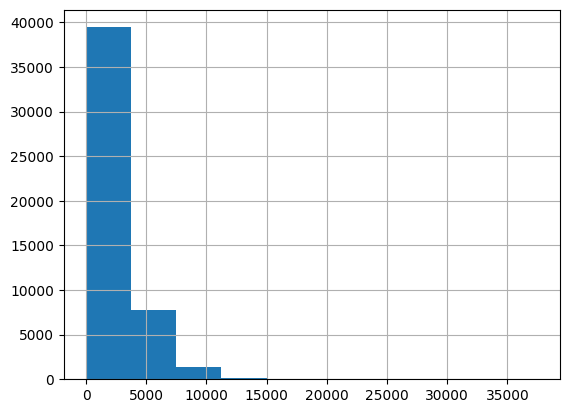

In [238]:
df['document_char_length'].hist()

## Word frequency
Are there some recurring words accross documents ? Think of administrative jargon

In [239]:
documents = df['Avis'].values.tolist()

In [276]:
def document_preprocessing(document):
    """Normalize documents with some preprocessing tasks"""
    # tokenize
    document = nlp(document)
    # lemmatize
    tokens = [token.lemma_ for token in document]
    # remove stopwords
    tokens = [tk for tk in tokens if tk not in STOP_WORDS]
    return tokens

Are there very discriminative words between positive and negative classes ? Let's compare word frequencies.

In [241]:
# preprocessing is time consuming so we sample fewer documents.
documents_positive = df.loc[df.label_class=='favorable', 'Avis'].sample(2000).values.tolist()
documents_negative = df.loc[df.label_class=='défavorable', 'Avis'].sample(2000).values.tolist()
# documents_neutral = df.loc[df.label_class=='sans objet', 'Avis'].sample(2000).values.tolist()

In [243]:
tokens_positive = [document_preprocessing(doc) for doc in documents_positive]
tokens_negative = [document_preprocessing(doc) for doc in documents_negative]

In [270]:
def generate_word_count(documents):
    """Compute word frequency given a list of documents"""
    counter = Counter()
    for doc in documents:
        counter += Counter(doc)   
    return counter

documents_word_frequency_positive = generate_word_count(tokens_positive)
documents_word_frequency_negative = generate_word_count(tokens_negative)

In [273]:
(documents_word_frequency_positive - documents_word_frequency_negative).most_common()

[(')', 3230),
 (',', 3192),
 ('-', 2781),
 ('1', 2409),
 ('public', 2014),
 ('favorable', 1995),
 ('article', 1902),
 (';', 1746),
 ('code', 1731),
 ('réserve', 1488),
 ('application', 1462),
 ('administration', 1446),
 ('\n', 1371),
 ('L311', 1146),
 ('relation', 1099),
 ('2', 1000),
 ('demande', 941),
 ('document', 849),
 ('point', 812),
 ('administratif', 780),
 ('communicable', 735),
 ('\r\n', 735),
 ('environnement', 716),
 ('avis', 691),
 ('santé', 670),
 ('absence', 657),
 ('mention', 646),
 ('5', 579),
 ('date', 529),
 ('faire', 522),
 ('mentionner', 511),
 ('.', 491),
 (':', 490),
 ('compte', 490),
 ('rapport', 478),
 ('nom', 436),
 ('collectivité', 436),
 ('devoir', 432),
 ('registre', 429),
 ('maire', 424),
 ('territorial', 415),
 ('(', 413),
 ('isolement', 408),
 ('émettre', 386),
 ('contention', 385),
 ('établissement', 379),
 ('copie', 373),
 ('vertu', 367),
 ('occultation', 367),
 ('caisse', 366),
 ('frais', 356),
 ('6', 340),
 ('pratique', 324),
 ('commune', 323),
 ('dé

In [274]:
(documents_word_frequency_negative - documents_word_frequency_positive).most_common()

[('défavorable', 1682),
 ('secret', 811),
 ('communication', 664),
 ('porter', 657),
 ('national', 593),
 ('défense', 564),
 ('médical', 544),
 ('défunt', 448),
 ('cause', 437),
 ('connaissance', 429),
 ('droit', 428),
 ('pouvoir', 397),
 ('adresser', 387),
 ('décéder', 378),
 ('espèce', 355),
 ('part', 353),
 ('procédure', 343),
 ('objectif', 333),
 ('délai', 327),
 ('lettre', 326),
 ('monsieur', 325),
 ('enfant', 325),
 ('auteur', 323),
 ('comportement', 313),
 ('nécessaire', 300),
 ('préjudice', 283),
 ('Monsieur', 273),
 ('tiers', 266),
 ('équipe', 263),
 ('mémoire', 262),
 ('protéger', 254),
 ('permettre', 236),
 ('informer', 235),
 ('obstacle', 231),
 ('motif', 231),
 ('législateur', 230),
 ('fiscal', 227),
 ('atteinte', 225),
 ('justifier', 220),
 ('signalement', 218),
 ('valoir', 218),
 ('dénonciation', 216),
 ('«', 213),
 ('»', 211),
 ('patrimoine', 211),
 ('qualité', 205),
 ('prendre', 203),
 ('connaître', 200),
 ('ministre', 198),
 ('impôt', 197),
 (' ', 193),
 ('caractère',

In [ ]:
documents_word_frequency_positive - documents_word_frequency_negative

Some tokens have obviously strong discriminative power:

For the Défavorable class: `défavorable`, `préjudice`, ... and defence related vocabulary (
